Dataset shape: (12020, 2)


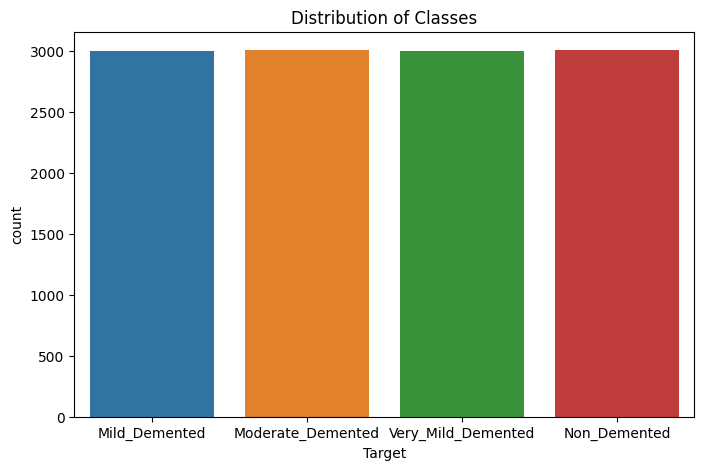

Found 9616 validated image filenames belonging to 4 classes.
Found 2404 validated image filenames belonging to 4 classes.


In [1]:
import os
import glob
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.models import Model
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNet,VGG16,VGG19, MobileNetV2, ResNet50, ResNet101,ResNet152, InceptionV3,InceptionResNetV2,DenseNet121,DenseNet169,DenseNet201,Xception,NASNetMobile, NASNetLarge
from keras.applications.inception_v3 import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix

DATA_PATH = "/kaggle/input/preprocess-dataset-augmentation/AD_AUG"
def load_data(data_path):
    all_paths = glob.glob(f'{data_path}/**/*.*', recursive=True)
    labels = [os.path.split(os.path.split(path)[0])[1] for path in all_paths]
    return pd.DataFrame({'Filepath': all_paths, 'Target': labels}).sample(frac=1).reset_index(drop=True)

dataframe = load_data(DATA_PATH)
def explore_data(df):
    print("Dataset shape:", df.shape)
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df, x='Target')
    plt.title("Distribution of Classes")
    plt.show()
    dataframe = load_data(DATA_PATH)
explore_data(dataframe)
import cv2
import numpy as np
from skimage.feature import local_binary_pattern
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Preprocessing: Grayscale,Denoising,CLAHE,Resize,Rescale
#Local Binary Pattern (LBP) for feature extraction

def preprocess_image(filepath):

    image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)

    image = cv2.fastNlMeansDenoising(image, None, 10, 7, 21)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    image = clahe.apply(image)

    image = cv2.resize(image, (128, 128))

    image = image / 255.0

    lbp = local_binary_pattern(image, P=8, R=1, method="uniform")

    return lbp
def prepare_data(df):

    datagen = ImageDataGenerator(validation_split=0.2)

    def custom_image_loader(filepath):
        processed_image = preprocess_image(filepath)
        return np.expand_dims(processed_image, axis=-1)

    train_data = datagen.flow_from_dataframe(
        df, x_col='Filepath', y_col='Target', target_size=(128, 128), batch_size=16, subset='training',
        class_mode='categorical', shuffle=True,
        preprocessing_function=custom_image_loader
    )
    test_data = datagen.flow_from_dataframe(
        df, x_col='Filepath', y_col='Target', target_size=(128, 128), batch_size=16, subset='validation',
        class_mode='categorical', shuffle=False,
        preprocessing_function=custom_image_loader
    )

    return train_data, test_data


train_data, test_data = prepare_data(dataframe)


# **Load Pre-trained VGG16 and VGG19 Models**

In [39]:
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

# Load VGG16 without the top classification layer
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
vgg16_base.trainable = False  # Freeze the base model

# Add custom layers for VGG16
x = vgg16_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)  # L2 regularization
x = Dropout(0.6)(x)
vgg16_output = Dense(4, activation='softmax')(x)  # Assuming 4 classes for Alzheimer's disease

# Create the VGG16 model
vgg16_model = Model(inputs=vgg16_base.input, outputs=vgg16_output)

# Load VGG19 without the top classification layer
vgg19_base = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
vgg19_base.trainable = False  # Freeze the base model

# Add custom layers for VGG19
x = vgg19_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)  # L2 regularization
x = Dropout(0.6)(x)
vgg19_output = Dense(4, activation='softmax')(x)  # Assuming 4 classes for Alzheimer's disease

# Create the VGG19 model
vgg19_model = Model(inputs=vgg19_base.input, outputs=vgg19_output)

# **Compile Both Models**

In [40]:
# Compile VGG16
vgg16_model.compile(optimizer=Adam(learning_rate=0.0001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

# Compile VGG19
vgg19_model.compile(optimizer=Adam(learning_rate=0.0001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

# ** Train Both Models**

In [41]:
# Train VGG16
vgg16_history = vgg16_model.fit(
    train_data,
    validation_data=test_data,
    epochs=50,  # Adjust the number of epochs as needed
    verbose=1
)

# Train VGG19
vgg19_history = vgg19_model.fit(
    train_data,
    validation_data=test_data,
    epochs=50,  # Adjust the number of epochs as needed
    verbose=1
)

Epoch 1/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.3259 - loss: 8.8231 - val_accuracy: 0.6834 - val_loss: 2.7320
Epoch 2/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.5590 - loss: 3.0248 - val_accuracy: 0.7629 - val_loss: 2.1436
Epoch 3/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.6640 - loss: 2.2868 - val_accuracy: 0.8045 - val_loss: 1.7999
Epoch 4/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.7133 - loss: 1.9302 - val_accuracy: 0.8378 - val_loss: 1.5589
Epoch 5/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.7314 - loss: 1.6889 - val_accuracy: 0.8540 - val_loss: 1.3606
Epoch 6/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.7705 - loss: 1.4884 - val_accuracy: 0.8677 - val_loss: 1.2011
Epoch 7/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.7877 - loss: 1.3279 - val_accuracy: 0.8710 - val_loss: 1.0833
Epoch 8/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.8079 - loss: 1.1917 - 

# **Combine Predictions Using Averaging**

In [42]:
# Get predictions from VGG16 and VGG19
vgg16_predictions = vgg16_model.predict(test_data)
vgg19_predictions = vgg19_model.predict(test_data)

# Average the predictions
ensemble_predictions = (vgg16_predictions + vgg19_predictions) / 2

# Convert probabilities to class labels
ensemble_pred_labels = np.argmax(ensemble_predictions, axis=1)

151/151 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step


# **Evaluate the Ensemble Model**

Classification Report:
                    precision    recall  f1-score   support

     Mild_Demented       0.94      0.96      0.95       597
 Moderate_Demented       1.00      1.00      1.00       586
      Non_Demented       0.97      0.99      0.98       634
Very_Mild_Demented       0.96      0.91      0.93       587

          accuracy                           0.97      2404
         macro avg       0.97      0.97      0.97      2404
      weighted avg       0.97      0.97      0.97      2404

Confusion Matrix:
[[574   0   5  18]
 [  0 586   0   0]
 [  2   0 630   2]
 [ 36   2  17 532]]


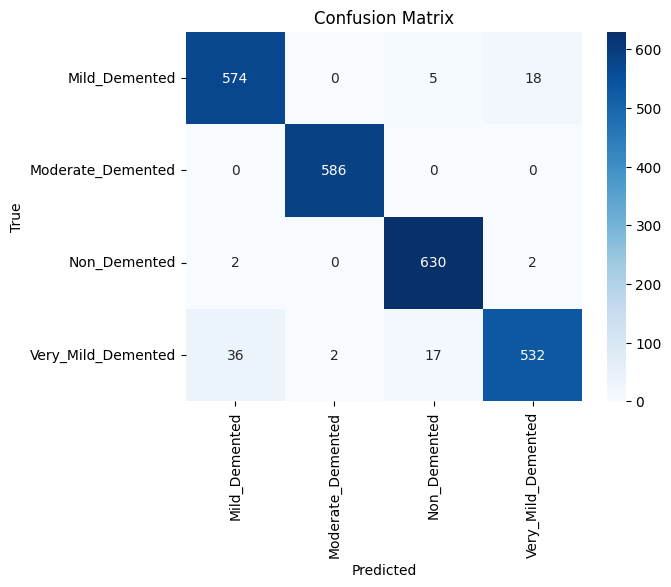

In [43]:
from sklearn.metrics import classification_report, confusion_matrix

# True labels
true_labels = test_data.labels 

# Classification report
print("Classification Report:")
print(classification_report(true_labels, ensemble_pred_labels, target_names=test_data.class_indices.keys()))

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, ensemble_pred_labels)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_data.class_indices.keys(), yticklabels=test_data.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

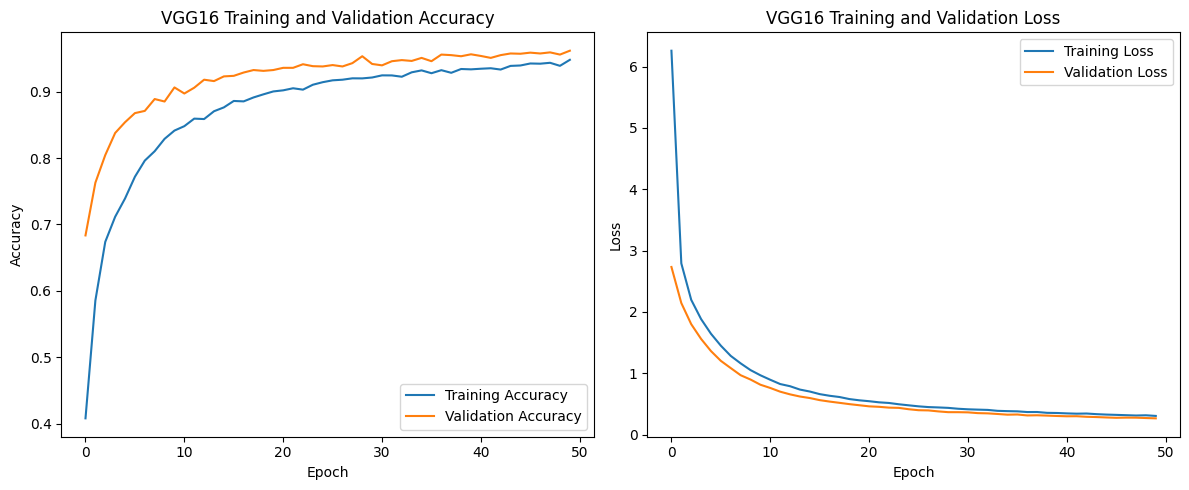

In [44]:
# Plot training & validation accuracy for VGG16
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(vgg16_history.history['accuracy'], label='Training Accuracy')
plt.plot(vgg16_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('VGG16 Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(vgg16_history.history['loss'], label='Training Loss')
plt.plot(vgg16_history.history['val_loss'], label='Validation Loss')
plt.title('VGG16 Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

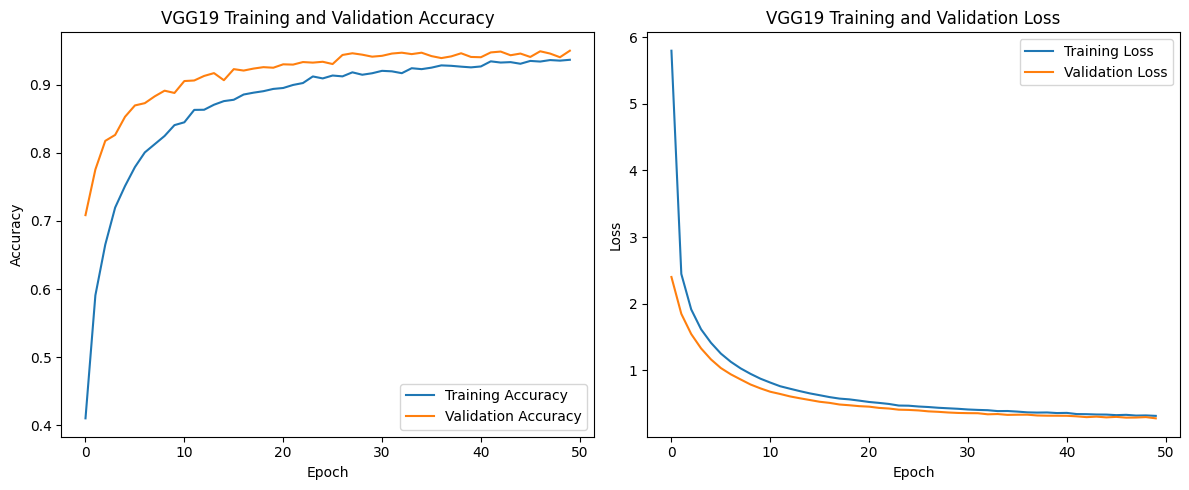

In [45]:
# Plot training & validation accuracy for VGG19
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(vgg19_history.history['accuracy'], label='Training Accuracy')
plt.plot(vgg19_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('VGG19 Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(vgg19_history.history['loss'], label='Training Loss')
plt.plot(vgg19_history.history['val_loss'], label='Validation Loss')
plt.title('VGG19 Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

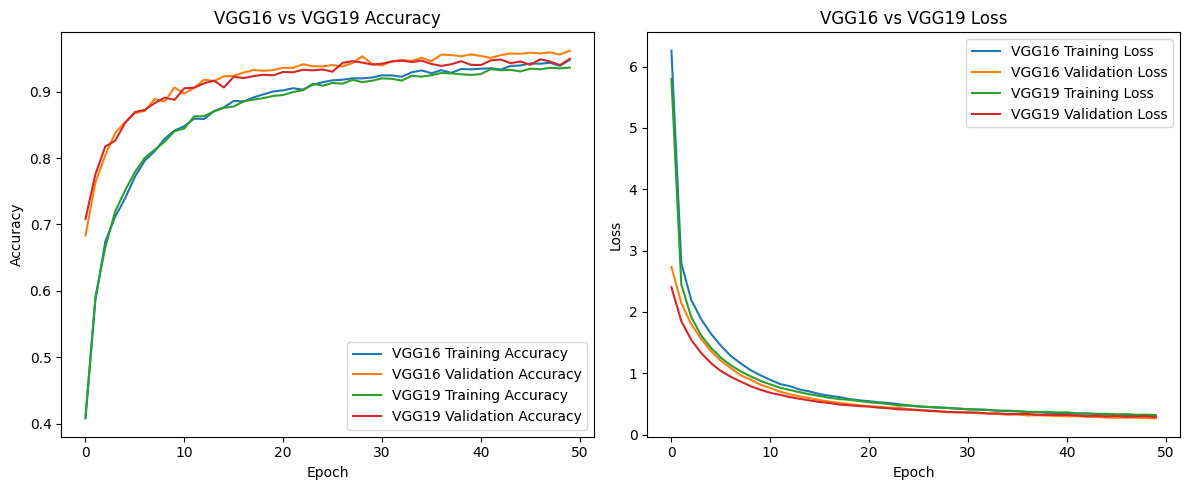

In [46]:
# Plot accuracy comparison
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(vgg16_history.history['accuracy'], label='VGG16 Training Accuracy')
plt.plot(vgg16_history.history['val_accuracy'], label='VGG16 Validation Accuracy')
plt.plot(vgg19_history.history['accuracy'], label='VGG19 Training Accuracy')
plt.plot(vgg19_history.history['val_accuracy'], label='VGG19 Validation Accuracy')
plt.title('VGG16 vs VGG19 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss comparison
plt.subplot(1, 2, 2)
plt.plot(vgg16_history.history['loss'], label='VGG16 Training Loss')
plt.plot(vgg16_history.history['val_loss'], label='VGG16 Validation Loss')
plt.plot(vgg19_history.history['loss'], label='VGG19 Training Loss')
plt.plot(vgg19_history.history['val_loss'], label='VGG19 Validation Loss')
plt.title('VGG16 vs VGG19 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()